In [54]:
import os
from glob import glob
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import skimage.exposure
from scipy import ndimage
from scipy import signal

import cv2 as cv
from PIL import Image, ImageOps

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


### **Create X and y**

In [147]:
AorC = 'Cathodic' # 'Anodic' or 'Cathodic'
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'

data_dir = os.path.join(os.path.join(base_dir, 'data'), 'Fig4')
fig_dir = os.path.join(os.path.join(base_dir, 'figures'), 'Fig4')

if AorC == 'Anodic':
  PATH = os.path.join(data_dir, 'Anodic')
elif AorC == 'Cathodic':
  PATH = os.path.join(data_dir, 'Cathodic')

os.chdir(PATH)

for (i, filename) in enumerate(sorted(glob('*.png'))):
  tmp_X = cv.imread(os.path.join(PATH, filename), cv.IMREAD_GRAYSCALE)

  tmp_X = np.array(tmp_X.astype(np.float32)[:320, :320])
  tmp_X = np.expand_dims(tmp_X, axis=0)

  if i == 0:
    X = tmp_X
    h,  w = X.shape[1], X.shape[2]
  else:
    tmp_X = tmp_X[:, :h, :w]
    X = np.concatenate([X, tmp_X], axis=0)

y = np.array([0] * X.shape[0])
print(X.shape, y.shape)
print(np.unique(y))
print(X.min(), X.max(), y.min(), y.max())

(7, 320, 320) (7,)
[0]
0.0 241.0 0 0


### **Detect edges**

In [148]:
rainbow = {0: (255, 14, 1),
           1: (254, 157, 1),
           2: (229, 198, 1),
           3: (1, 229, 1),
           4: (1, 171, 255),
           5: (1, 27, 255), 
           6: (110, 1, 199),
           7: (140, 1, 1),}

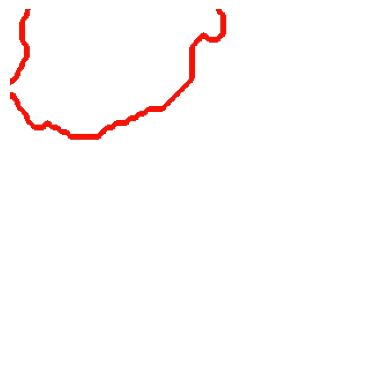

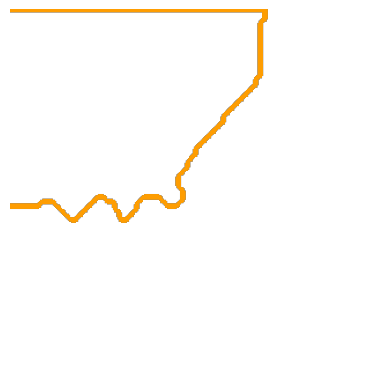

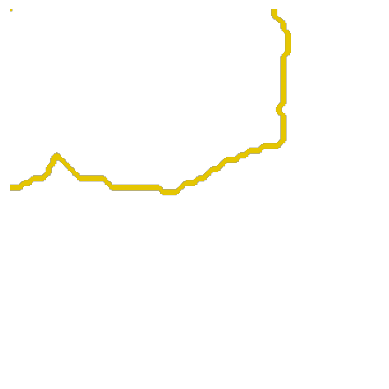

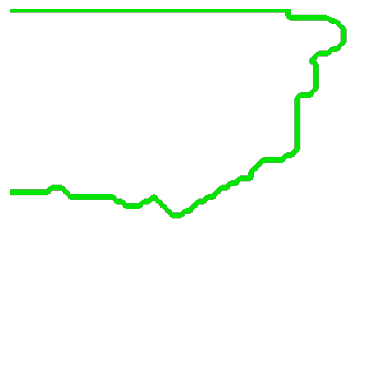

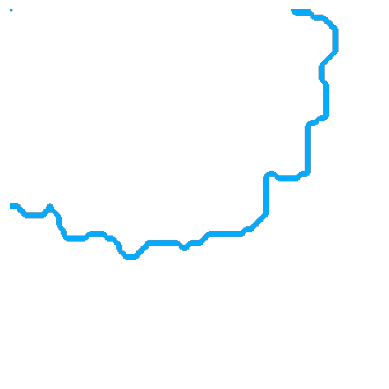

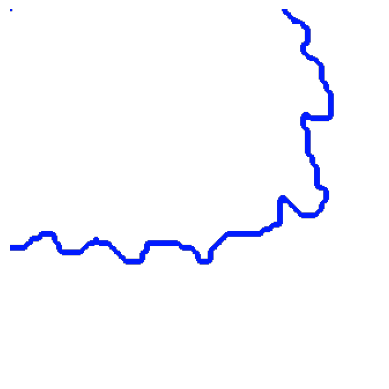

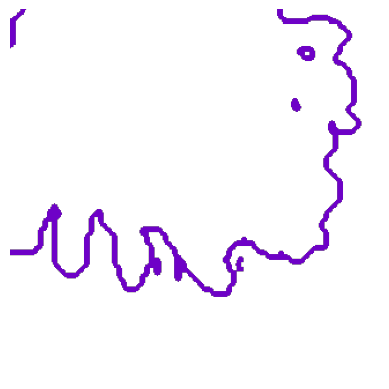

In [149]:
for i in range(X.shape[0]):
  img = X[i, :, :]

  # get the outer borderline only
  binary = np.where(img > 0, 255, img) # the most outer boarder

  # edge detect with Canny operator
  binary = np.uint8(binary)
  canny = cv.Canny(binary, 100, 200)

  # make it into binary image
  binary2 = np.where(canny < 128, 0, canny)
  binary2 = np.where(canny >= 128, 255, canny)

  # smooth the edge
  blur = cv.GaussianBlur(binary2, ksize=(0, 0), sigmaX=1, sigmaY=1, borderType = cv.BORDER_DEFAULT) 

  # make it into binary image
  binary3 = np.where(blur > 0, 255, blur)

  # to make colorful contour lines
  colored = np.expand_dims(binary3, axis=-1)
  colored = np.concatenate([colored, colored, colored], axis=-1)
  
  colored = np.where(colored==(255, 255, 255), rainbow[i], colored)
  colored = colored / 255. # change it to float

  alphas = np.ones((colored.shape[0], colored.shape[1]))
  alphas = np.where(colored[:, :, 0] == 0, 0, alphas)
  alphas = np.expand_dims(alphas, axis=-1)

  colored = np.concatenate([colored, alphas], axis=-1)

  # thin out the edges
  kernel = np.ones((3, 3), np.uint8)
  eroded = cv.erode(colored, kernel, iterations=1)

  # visualize 
  plt.imshow(eroded, cmap='gray') 
  plt.axis('off')
  plt.xticks([])
  plt.yticks([])
  plt.show()

  # save the image
  plt.imsave(os.path.join(os.path.join(fig_dir, f'{AorC}'), f'{i}.png'), eroded)